In [1]:
# IRL AutoRegressive 5
# In this algorithm, the IRL is re-derived from Maximum Entropy principle.
# An additional linear transformation is added to the feature space, transforming the feature space into an expanded feature space 
# to ensure the scatteredness of the feature data in a set is kept constant, allowing for a more optimal learning by IRL.

The Bayesian IRL - Modified Entropy:

<!-- In the old version of IRL we were aiming to maximize the likelihood of what is believed to be the optimal trajectory $\tau^*$ based on how we cange the weights $w$: 

$L(\tau^*|w) = \Large\frac{P(w|\tau^*)P(\tau^*)}{P(w)} = \frac{P(w, \tau^*)}{\sum_{i=1}^K P(w|\tau_i)P(\tau_i)} = \Large\frac{\exp(-w^T\Phi^*)}{\sum_i^K \exp(-w^T\Phi_i)}$

For new version, we condition all $P(\tau_i)$ on the full set of trajectories $\bar\tau$.
This means that now all the probabilities are considered conditional all trajectories, i.e., $P(\tau_i) \rightarrow P(\tau_i|\bar\tau)$.
So we have:

$P(\tau^*|w,\tau) = \Large\frac{P(w|\tau^*,\bar\tau)P(\tau^*|\bar\tau)}{P(w|\bar\tau)} = \frac{P(w|\tau^*,\tau)P(\tau^*|\tau)}{\sum_{j=1}^K P(w|\tau_j,\bar\tau)P(\tau_j|\bar\tau)}$

We can correctly assume that $w$ and $\bar\tau$ are conditionally independent. 
This means that when we have information about $\tau^*$, $\bar\tau$ has no additional information to offer for probability of $w$, hence:

$P(w|\tau*, \bar\tau) = P(w|\tau^*) \Rightarrow P(\tau^*|w,\tau) = \Large\frac{P(w|\tau^*)P(\tau^*|\tau)}{\sum_{j=1}^K P(w|\tau_j)P(\tau_j|\bar\tau)}$

Given Bayes Rule, we can rewrite $P(\tau_j|\bar\tau)$ as:

$P(\tau_j|\bar\tau) = \Large \frac{P(\bar\tau|\tau_j)P(\tau_j)}{P(\bar\tau)}$

$\Rightarrow \normalsize P(\tau^*|w,\tau) = 
\LARGE \frac{\frac{P(w|\tau^*)P(\bar\tau|\tau^*)P(\tau^*)}{P(\bar\tau)}}{\sum_{j=1}^K \frac{P(w|\tau_j)P(\bar\tau|\tau_j)P(\tau_j)}{P(\bar\tau)}} = \frac{P(w|\tau^*)P(\bar\tau|\tau^*)P(\tau^*)}{\sum_{j=1}^K P(w|\tau_j)P(\bar\tau|\tau_j)P(\tau_j)} = \frac{P(w, \tau^*)P(\bar\tau|\tau^*) }{\sum_{j=1}^K P(w,\tau_j)P(\bar\tau|\tau_j)} = \frac{\exp(-w^T\Phi^*)P(\bar\tau|\tau^*)}{\sum_{j=1}^K \exp(-w^T\Phi_j) P(\bar\tau|\tau_j)}$

We can already see the effect of considering the conditionality of the likelihood on $\bar\tau$ in the expression by comparing it to the old one.

We can assume that the likelihood of occurance for both $\bar\tau$ and $\tau_j$ are constant and equal to 1, but we can assume a conditional probability for their occurance. With this assumption, and Bayes Rule we have:

$P(\tau_j|\bar\tau) = P(\bar\tau|\tau_j)$

The expression on the left side addresses the probability of trajectory $\tau_j$ being resulted from a set of trajectories $\bar\tau$, while the expression on the right, means how likely it is that the trajectory set $\bar\tau$ contains a trajectory $\tau_j$. These definitions are the same in theory, which corroborates the equality above. 

For example, a set that has trajectories that are close to $\tau_j$ have a higher chance to have generated (or contained) this trajectory, rather than a set that has trajectories that are far away from $\tau_j$. This also means that trajectory $\tau_j$ is more likely to have been generated (or contained) in a set with close trajectories to it, rather than not.

If we define: $P(\bar\tau|\tau_j) = ***$.

So the with this new conditional probability of trajectories, the likelihood of trajectory $i$ in the set will be determined by:

$L(\tau_i|w,\tau) = \Large\frac{A}{B}$ -->

In [2]:
import crocoddyl
import pinocchio
from IPython.display import HTML
import mim_solvers
import numpy as np
import random
from matplotlib import animation
from matplotlib import pyplot as plt
from PointMass_utils import *
from PointMass_model import *
from scipy.optimize import minimize
from scipy.optimize import Bounds

In [3]:
nx = 4
nu = 2
T = 50
start_point = np.array([0, 0, 0, 0])
target_low = np.array([10, 0, 0, 0])
target_high = np.array([10, 10, 0, 0])
obs_act = 1
obs0 = Obstacle(10, 8, 2, obs_act, 'Obs0')
obs1 = Obstacle(3, 3.5, 1, obs_act, 'Obs1')
obs2 = Obstacle(8, 7, 1, obs_act, 'Obs2')
obs3 = Obstacle(4.5, 7, 1, obs_act, 'Obs3')
obs4 = Obstacle(6, 4.5, 1, obs_act, 'Obs4')
obs5 = Obstacle(6.5, 9, 1, obs_act, 'Obs5')
obs6 = Obstacle(7.5, 3, 1, obs_act, 'Obs6')
obs7 = Obstacle(5, 1, 1, obs_act, 'Obs7')
obs8 = Obstacle(2.5, 2, 1, obs_act, 'Obs8')
obs_set = [obs1, obs2, obs3, obs4, obs5]#, obs6, obs7, obs8]
# obs_set = [obs0]
translation_cost = XReg(nx, target_high, 'trans_high')
xreg = XReg(nx, start_point, 'XReg')
ureg = UReg(nu, None, 'UReg')

cost_set = Costs()
cost_set.add_cost(translation_cost)
cost_set.add_cost(xreg)
cost_set.add_cost(ureg)
# cost_set.add_cost(obs0)
cost_set.add_cost(obs1)
cost_set.add_cost(obs2)
cost_set.add_cost(obs3)
cost_set.add_cost(obs4)
cost_set.add_cost(obs5)
# cost_set.add_cost(obs6)
# cost_set.add_cost(obs7)
# cost_set.add_cost(obs8)

nr = cost_set.nr

In [4]:
# Desired Weights
w_run_possibles = np.array([10, 1., 1., 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000])
w_term_possibles = np.array([2000, 1., 1., 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000])
w_run = w_run_possibles[:nr]
w_term = w_term_possibles[:nr]
obs_set = obs_set[:nr]
# w_des = np.hstack([w_run, w_term])
w_des = (np.hstack([w_run, w_term])/(np.max(np.hstack([w_run, w_term])))).copy()
# w_des = (np.hstack([w_run, w_term])/(np.linalg.norm(np.hstack([w_run, w_term])))).copy()

In [5]:
samples = 10
xlims = [0, 10]
ylims = [0, 10]
x0 = start_point
u0 = np.array([0.0, 0.0])
timeStep = 5e-2
max_iter = 500
# XS_Set_optimal, US_Set_optimal = test_model_full(cost_set, obs_set, samples, xlims, ylims, T, w_des, timeStep, max_iter, with_callback = False)
# xs_optimal = XS_Set_optimal[0]
# us_optimal = US_Set_optimal[0]
xs_optimal, us_optimal, _ = get_results_from_model(cost_set, x0, u0, T, w_des, timeStep, max_iter, with_callback = True)

iter     merit         cost         grad      step    ||gaps||        KKT
   1  1.01250e+02  1.01250e+02  2.91940e+01  1.0000  0.00000e+00  9.97972e+00
   2  1.41523e+00  1.41523e+00  1.76175e+00  1.0000  1.75138e-14  8.56175e-02
   3  1.30994e+00  1.30994e+00  1.15340e+00  1.0000  4.16099e-09  3.20230e-02
   4  1.27905e+00  1.27905e+00  1.61225e+01  1.0000  2.66369e-09  3.01823e-01
   5  1.23371e+00  1.23371e+00  8.43120e+00  1.0000  3.37438e-08  1.07231e-01
   6  1.15231e+00  1.15231e+00  4.25717e+00  1.0000  1.81090e-08  2.63420e-02
   7  1.13773e+00  1.13773e+00  3.31754e-01  1.0000  1.06888e-08  3.08738e-03
   8  1.13741e+00  1.13741e+00  6.03318e-01  1.0000  7.95967e-10  1.99566e-03
   9  1.13712e+00  1.13712e+00  8.75337e-02  1.0000  1.66353e-09  8.68779e-04
  10  1.13710e+00  1.13710e+00  1.08437e-01  1.0000  2.09108e-10  1.10348e-03
iter     merit         cost         grad      step    ||gaps||        KKT
  11  1.13708e+00  1.13708e+00  2.20353e+00  0.5000  2.67546e-10  2.2517

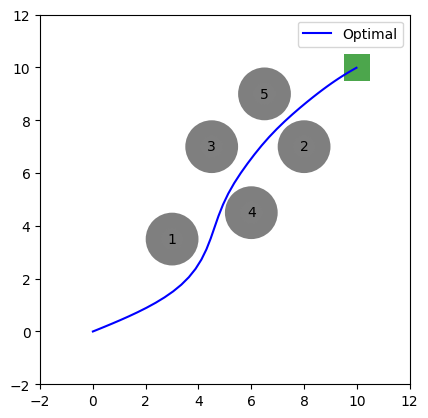

In [6]:
# HTML(animatePointMass(xs_optimal, obs_set, target_high).to_jshtml())
plot_1_traj(np.vstack(xs_optimal), obs_set, target_high, label='Optimal', linemap = 'b')

In [7]:
# Bad Running and Terminal Model
w_bad = np.zeros_like(w_des)
w_run = w_bad[:nr]
w_term = w_bad[nr:]

xs_non_optimal, us_non_optimal, sqp_non_opt = get_results_from_model(cost_set, x0, u0, T, w_bad, timeStep, max_iter, with_callback = False)

In [8]:
# HTML(animatePointMass(xs_non_optimal, obs_set, target_high).to_jshtml())
# plot_1_traj(np.vstack(xs_non_optimal), obs_set, target_high, label='Non-Optimal', linemap = 'r')

In [28]:
# IRL Algorithm
def pick_highs(opt_vals, num):
    vals = np.stack(opt_vals)
    inds = sorted(range(len(vals)), key=lambda i: vals[i])[-num:][::-1]
    return inds

def pick_lows(opt_vals, num):
    vals = np.stack(opt_vals)
    inds = sorted(range(len(vals)), key=lambda i: vals[i])[:num][::-1]
    return inds

def get_cov(X):
    m = get_mean(X)
    s = np.zeros(shape=(m.shape[0],m.shape[0]))
    for x in X:
        s += (x[:,None]-m[:,None])@(x[:,None]-m[:,None]).T
    s /= len(X)
    # s += np.identity(m.shape[0])*1e-15 # Regularization
    return s

def get_mean(X):
    m = np.zeros(shape=X[0].shape)
    for x in X:
        m += x
    m /= len(X)
    return np.squeeze(m)

def get_mean_cov(phis, scale = 0.0):
    # The new feature space will attain a covariance with 
    # our determined eigenvalues, if the features are pre-multiplied by 'cov_inv_sqrt'.
    # If scale = 0.0, the eigenvalues are all 1, if scale = 1.0, the eigenvalues won't change.
    
    new_phis = []
    phis = np.stack(phis)
    mean = get_mean(phis)
    cov = get_cov(phis)
    EVal, EVec = np.linalg.eig(cov)
    EV_new = np.exp((scale)*(np.log(EVal)))
    C_p = EVec@(np.diag(np.sqrt(EVal/EV_new)))@EVec.T
    cov_inv_sqrt = np.linalg.inv(C_p)
    return mean, cov, cov_inv_sqrt

def get_phi_set(cost_set, xs, us, dt):
    phis = []
    for i, (X, U) in enumerate(zip(xs, us)):
        phis.append(cost_set.cum_feat(X, U, dt))
    return phis

def likelihood(cost_set, x_opt, u_opt, xs_set, us_set, w_run, w_term, dt, set_params):
    phis = []
    costs = []
    if set_params['use_norm']:
        # set_params['mean'] = set_params['phi_opt']
        cost_opt, phi_opt = cost_set.traj_cost_and_feat_modified(x_opt, u_opt, w_run, w_term, dt, set_params['zero_mean'],set_params['cov_inv_sqrt']) 
        phis.append(phi_opt); costs.append(cost_opt)
        for x_, u_ in zip(xs_set, us_set):
            cost_nopt, phi_nopt = cost_set.traj_cost_and_feat_modified(x_, u_, w_run, w_term, dt, set_params['zero_mean'],set_params['cov_inv_sqrt']) 
            phis.append(phi_nopt); costs.append(cost_nopt)
    else:
        cost_opt, phi_opt = cost_set.traj_cost_and_feat(x_opt, u_opt, w_run, w_term, dt) 
        phis.append(phi_opt); costs.append(cost_opt)
        for x_, u_ in zip(xs_set, us_set):
            cost_nopt, phi_nopt = cost_set.traj_cost_and_feat(x_, u_, w_run, w_term, dt) 
            phis.append(phi_nopt); costs.append(cost_nopt)
    
    ll = 0.0
    num = 0.0
    den = 0.0
    
    # num = np.max([np.nextafter(0,1),np.exp(-cost_opt)])
    num = 1.0
    den = 1.0
    for phi_, cost_ in zip(phis[1:], costs[1:]):
        den += np.max([np.nextafter(0,1),(np.exp(-(cost_ - cost_opt)))])
    
    ll = num/den
    return ll
            
def KL_D(cost_set, xs, us, w_old, w_new, dt, set_params):
    nr = cost_set.nr
    kl_array = np.zeros(len(xs))
    Px = np.zeros(len(xs))
    Qx = np.zeros(len(us))
    kl_div = 0.0
    for i, (X, U) in enumerate(zip(xs,us)):
        xs_temp = xs.copy(); xs_temp.pop(i)
        us_temp = us.copy(); us_temp.pop(i)
        Px[i] = likelihood(cost_set, X, U, xs_temp, us_temp, w_old[:nr], w_old[nr:], dt, set_params)
        Qx[i] = likelihood(cost_set, X, U, xs_temp, us_temp, w_new[:nr], w_new[nr:], dt, set_params)
    Px = Px/np.sum(Px)
    Qx = Qx/np.sum(Qx)
    kl_array = Px*np.log(Px/Qx)
    kl_div = np.sum(kl_array)
    return kl_div, kl_array


def fcn_w(x, cost_set, xs_optimal, us_optimal, xs_non_optimal_set, us_non_optimal_set, dt, set_params, Lambda = 0.001):
    nr = cost_set.nr
    output = 0
    consider_const = False
    x_run = x[:nr]; x_term = x[nr:]
    if consider_const:
        x_run[3:] = x_run[-1]
        x_term[3:] = x_term[-1]
    ll = likelihood(cost_set, xs_optimal, us_optimal, xs_non_optimal_set, us_non_optimal_set, x_run, x_term, dt, set_params)
    output -= np.log(ll)
    output += Lambda*np.linalg.norm(x)
    return output


In [44]:
# IRL Params
dt = timeStep
Lambda = 0.001
lb = 0; ub = np.inf
bnds = Bounds(lb, ub)
options = {'maxiter': 2, 'iprint': -1,'ftol': 1e-10 ,'gtol' : 1e-10}
tol = 1e-10
pick_best = True
pick_worst = False

w0 = w_bad
w_prev = w0
it = 0
max_set_size = 5
# it_max_IRL = max_set_size + 1
it_max_IRL = 50
it_min_IRL = max_set_size; it_min = True
it_max_sqp = 5

xs = []
us = []
xs_all = []
us_all = []
xs_non_optimal_set = []
us_non_optimal_set = []
ws = []
Fcns= []
Phis = []
KL_div = [10]; KL = 10
KL_arrs = []; KL_arrs.append(np.zeros(10))
Cost_Diffs = [1.0]
W_Diffs = [1.0]
Traj_Diffs = [1.0]
Opt_Vals = [1.0]
mean = np.zeros(cost_set.nr)
cov_inv_sqrt = np.identity(cost_set.nr)

xs_all.append(np.vstack(xs_optimal).copy()); xs_all.append(np.vstack(xs_non_optimal).copy())
us_all.append(np.vstack(us_optimal).copy()); us_all.append(np.vstack(us_non_optimal).copy())
xs_non_optimal_set.append(np.vstack(xs_non_optimal).copy()); xs.append(np.vstack(xs_non_optimal).copy())
us_non_optimal_set.append(np.vstack(us_non_optimal).copy()); us.append(np.vstack(us_non_optimal).copy())

ws.append(w_bad)

best_x = xs_non_optimal
best_u = us_non_optimal

init_choices = ['bad','optimal','previous', 'best']
stochastic = False
damping = 3
loop_tol = 1e-10
w_diff = 1
traj_diff = 1
opt_feat = cost_set.cum_feat(xs_optimal,us_optimal,dt);
non_opt_feat = cost_set.cum_feat(xs_non_optimal, us_non_optimal, dt);
optimality = (np.linalg.norm(opt_feat - non_opt_feat))/(np.linalg.norm(opt_feat - non_opt_feat))
prev_optimality = optimality
prev_kld = 11; KL = 10
prev_eig_norm = 1; eig_norm = 2
prev_det = 1; det = 2
d_opt = 1

# Dataset Params
set_params = {
    'use_norm': False,
    'mean': mean,
    'zero_mean': np.zeros_like(mean),
    'cov': None,
    'cov_inv_sqrt': cov_inv_sqrt,
    'phi_opt': opt_feat,
    'All_phis': [opt_feat, non_opt_feat],
    'Curr_set_x': [xs_optimal, xs_non_optimal],
    'Curr_set_u': [us_optimal, us_non_optimal],
    'Curr_set_phis': [opt_feat, non_opt_feat],
    'Set_phis': [non_opt_feat],
    'Set_eigs': [],
    'Set_dets': [],
    'Best_eigs': [],
    'Best_dets': []
}


while ((prev_eig_norm-eig_norm) != 0.0 and KL > loop_tol and it < it_max_IRL) or (it_min):

    sqp_non_opt = reset_weights(sqp_non_opt, w0[:nr], w0[nr:])
    prev_det = det; prev_eig_norm = eig_norm
    # if len(xs_all) > cost_set.nr:
    
    set_params['mean'], set_params['cov'], set_params['cov_inv_sqrt'] = get_mean_cov(set_params['All_phis'], scale = 0.0)
    reg = np.eye(set_params['cov'].shape[0])*0
    set_params['Set_eigs'].append(np.linalg.eig(set_params['cov'])[0])
    set_params['Set_dets'].append(np.linalg.det(set_params['cov']-reg))
    det = np.linalg.det(get_cov(set_params['Curr_set_phis'])-reg)
    set_params['Best_dets'].append(det)
    eig_norm = np.linalg.norm(np.linalg.eig(get_cov(set_params['Curr_set_phis'])-reg)[0])
    set_params['Best_eigs'].append(np.linalg.eig(get_cov(set_params['Curr_set_phis'])-reg))
    if it > nr:
        set_params['use_norm'] = True
        
    res = minimize(fcn_w, 
                   w0, 
                   args=(cost_set, xs_optimal, us_optimal, xs_non_optimal_set, us_non_optimal_set, dt, set_params, Lambda), 
                   bounds=bnds, 
                   method='L-BFGS-B', 
                   tol = tol,
                   options=options)
    
    w_curr = res.x.copy()
    # if set_params['use_norm']:
    #     w_curr = np.zeros_like(w0)[None,:]
    #     w_curr[:,nr:] = w_curr[:,nr:]@set_params['cov_inv_sqrt']
    #     w_curr[:,:nr] = w_curr[:,:nr]@set_params['cov_inv_sqrt']
    
    dw = normalize(np.squeeze(w_curr)) - w_prev
    # dw = np.squeeze(w_curr) - w_prev
    w_loop = w_prev + (dw/damping) 
    # w_loop = w_prev + dw*np.min([optimality, 1.0/damping])
    w_loop = normalize(w_loop); w_run = w_loop[:nr]; w_term = w_loop[nr:]
    fcn_value = fcn_w(w_loop, cost_set, xs_optimal, us_optimal, xs, us, dt, set_params, Lambda); Fcns.append(fcn_value)
    
    # initial = random.choice(init_choices)
    initial = 'previous'
    if initial == 'previous':
        # Warm-Start with previous trajectory
        xs_init = [sqp_non_opt.xs.copy()[i] for i in range(T+1)]
        us_init = [sqp_non_opt.us.copy()[i] for i in range(T)]
    elif initial == 'optimal':
        # Warm-Start with optimal trajectory
        xs_init = [xs_optimal[i] for i in range(T+1)]
        us_init = [us_optimal[i] for i in range(T)]
    elif initial == 'bad':
        # Warm-Start with zero trajectory
        xs_init = [x0 for i in range(T+1)]
        us_init = [u0 for i in range(T)]
    elif initial == 'best':
        xs_init = [best_x[i] for i in range(T+1)]
        us_init = [best_u[i] for i in range(T)]
    

    sqp_non_opt = reset_weights(sqp_non_opt, w_loop[:nr], w_loop[nr:])
    done = sqp_non_opt.solve(xs_init, us_init, it_max_sqp)
    new_traj_x = sqp_non_opt.xs.tolist().copy()
    new_traj_u = sqp_non_opt.us.tolist().copy()
    
    # Add the trajectory to the set
    xs.append(np.vstack(new_traj_x)); xs_all.append(np.vstack(new_traj_x))
    us.append(np.vstack(new_traj_u)); us_all.append(np.vstack(new_traj_u))
    ws.append(w_loop.copy())
    traj_feat = cost_set.cum_feat(new_traj_x, new_traj_u, dt); set_params['All_phis'].append(traj_feat)
    optimality = (np.linalg.norm(traj_feat - opt_feat))/(np.linalg.norm(opt_feat - non_opt_feat)); Opt_Vals.append(optimality)
    w_diff = np.linalg.norm(w_loop - w_prev); W_Diffs.append(w_diff)
    traj_diff = (sqp_non_opt.cost - cost_set.traj_cost(xs_optimal, us_optimal, w_loop[:nr], w_loop[nr:], dt))**2; Traj_Diffs.append(traj_diff)
    
    if optimality < prev_optimality:
        best_x = sqp_non_opt.xs.copy()
        best_u = sqp_non_opt.us.copy()

    set_params['Curr_set_phis'] = [opt_feat]
    
    if len(xs) < max_set_size:
        xs_non_optimal_set = xs
        us_non_optimal_set = us
    else:
        if pick_best:
            inds = pick_lows(Opt_Vals,max_set_size)
            xs_non_optimal_set = [xs[i] for i in inds]
            us_non_optimal_set = [us[i] for i in inds]
            set_params['Set_phis'] = [set_params['All_phis'][i] for i in inds]
            set_params['Curr_set_phis'] = set_merge(set_params['Curr_set_phis'], set_params['Set_phis'])
        elif pick_worst:
            inds = pick_highs(Opt_Vals,max_set_size)
            xs_non_optimal_set = [xs[i] for i in inds]
            us_non_optimal_set = [us[i] for i in inds]
            set_params['Set_phis'] = [set_params['All_phis'][i] for i in inds]
            set_params['Curr_set_phis'] = set_merge(set_params['Curr_set_phis'], set_params['Set_phis'])
        else:
            xs_non_optimal_set = xs[-max_set_size:]
            us_non_optimal_set = us[-max_set_size:]
            set_params['Set_phis'] = set_params['All_phis'][-max_set_size:]
            set_params['Curr_set_phis'] = set_merge(set_params['Curr_set_phis'], set_params['Set_phis'])
        
    
    if it > 0:
        set_params['use_norm'] = False
        xs_w_opt = set_merge([xs_optimal], xs_non_optimal_set); us_w_opt = set_merge([us_optimal], us_non_optimal_set)
        # KL, KL_arr = KL_D(cost_set, xs_all, us_all, w_prev, w_loop, dt); KL_div.append(KL); KL_arrs.append(KL_arr)
        # KL, KL_arr = KL_D(cost_set, xs_non_optimal_set, us_non_optimal_set, w_prev, w_loop, dt); KL_div.append(KL); KL_arrs.append(KL_arr)
        KL, KL_arr = KL_D(cost_set, xs_w_opt, us_w_opt, w_prev, w_loop, dt, set_params); KL_div.append(KL); KL_arrs.append(KL_arr)
        KL_des, _ = KL_D(cost_set, xs_w_opt, us_w_opt, w_des, w_loop, dt, set_params)
        print('Iter: {} || KLD: {:.5f} || Desired KLD: {:.5f} || Traj Diff: {:.4f}, || Opt_Div: {:.4f}'.format(
            it+1, KL, KL_des, traj_diff, optimality
        ))
        
    d_opt = prev_optimality - optimality
    prev_optimality = optimality
    # Initial W for IRL as previous weights
    w0 = w_loop.copy()
    w_prev = w0
    it += 1
    if it > it_min_IRL:
        it_min = False

    

print(res)
w_irl = ws[-3]

/tmp/ipykernel_35197/3674145802.py:38: RuntimeWarning: divide by zero encountered in log
  EV_new = np.exp((scale)*(np.log(EVal)))
/tmp/ipykernel_35197/3674145802.py:38: RuntimeWarning: invalid value encountered in log
  EV_new = np.exp((scale)*(np.log(EVal)))
/tmp/ipykernel_35197/3674145802.py:38: RuntimeWarning: invalid value encountered in multiply
  EV_new = np.exp((scale)*(np.log(EVal)))


Iter: 2 || KLD: 516.78155 || Desired KLD: 91.61890 || Traj Diff: 1878.3678, || Opt_Div: 0.5141
Iter: 3 || KLD: 0.01821 || Desired KLD: 66.06830 || Traj Diff: 1036.9137, || Opt_Div: 0.4967
Iter: 4 || KLD: 0.02049 || Desired KLD: 40.04091 || Traj Diff: 451.8655, || Opt_Div: 0.4807
Iter: 5 || KLD: 0.02182 || Desired KLD: 9.54291 || Traj Diff: 192.4010, || Opt_Div: 0.4621
Iter: 6 || KLD: 0.01850 || Desired KLD: 4.75684 || Traj Diff: 80.2710, || Opt_Div: 0.4429
Iter: 7 || KLD: 0.01112 || Desired KLD: 2.29536 || Traj Diff: 33.6216, || Opt_Div: 0.4261
Iter: 8 || KLD: 0.00871 || Desired KLD: 1.09483 || Traj Diff: 14.1469, || Opt_Div: 0.4125
Iter: 9 || KLD: 0.01035 || Desired KLD: 0.51519 || Traj Diff: 5.9214, || Opt_Div: 0.4017
Iter: 10 || KLD: 0.00109 || Desired KLD: 0.37013 || Traj Diff: 4.5331, || Opt_Div: 0.3983
Iter: 11 || KLD: 0.00086 || Desired KLD: 0.28149 || Traj Diff: 3.6063, || Opt_Div: 0.3941
Iter: 12 || KLD: 0.00838 || Desired KLD: 0.14256 || Traj Diff: 1.4967, || Opt_Div: 0.3892


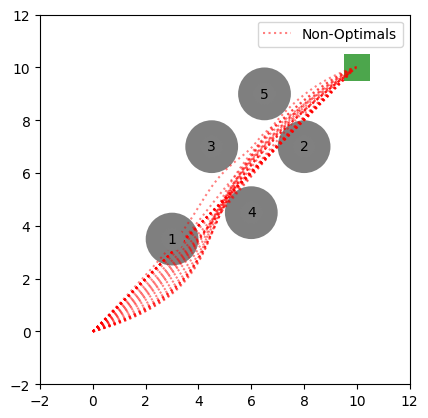

In [45]:
plot_1_set(xs, obs_set, target_high, label='Non-Optimals', linemap_traj='r:', linemap_set='r:')

processing the animation ... 
... processing done


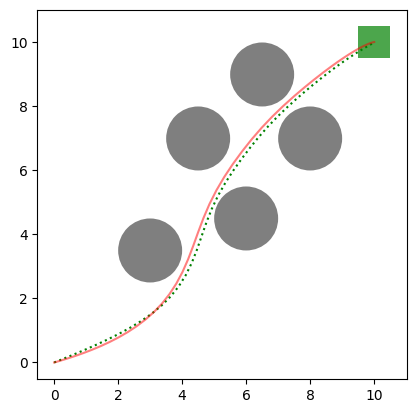

In [46]:
HTML(animateTraj(xs_optimal, xs[:-2], obs_set, target_high, max_set_size, sleep=500, animType=2).to_jshtml())

In [47]:
# w_irl = ws[-3]
for i, cost in enumerate(cost_set.costs):
    print(cost.name, ':')
    print('Running || ', 'Desired: ', w_des[:nr][i], 'IRL: ', w_irl[:nr][i])
    print('Terminal || ', 'Desired: ', w_des[nr:][i], 'IRL: ', w_irl[nr:][i])
    print('')

trans_high :
Running ||  Desired:  0.005 IRL:  0.0012821752847352044
Terminal ||  Desired:  1.0 IRL:  0.2747429245573736

XReg :
Running ||  Desired:  0.0005 IRL:  0.0
Terminal ||  Desired:  0.0005 IRL:  1.7119757503428336e-06

UReg :
Running ||  Desired:  0.0005 IRL:  0.0003857479473969514
Terminal ||  Desired:  0.0005 IRL:  0.001997554402907273

Obs1 :
Running ||  Desired:  1.0 IRL:  0.4232783773970137
Terminal ||  Desired:  0.5 IRL:  0.38067375657033675

Obs2 :
Running ||  Desired:  1.0 IRL:  1.0
Terminal ||  Desired:  0.5 IRL:  0.48644648532350154

Obs3 :
Running ||  Desired:  1.0 IRL:  0.430738752830594
Terminal ||  Desired:  0.5 IRL:  0.7776945655981883

Obs4 :
Running ||  Desired:  1.0 IRL:  0.6493837392225865
Terminal ||  Desired:  0.5 IRL:  0.39715901936615394

Obs5 :
Running ||  Desired:  1.0 IRL:  0.7501310443541435
Terminal ||  Desired:  0.5 IRL:  0.6581311116521459



In [48]:
print('Desired:                 ', fcn_w(w_des, cost_set, xs_optimal, us_optimal, xs, us, dt, set_params, Lambda)) 
print('IRL:                     ', fcn_w(w_irl, cost_set, xs_optimal, us_optimal, xs, us, dt, set_params, Lambda))
print('')
print('Desired Trajectory Cost: ', cost_set.traj_cost(xs_optimal, us_optimal, w_des[:nr], w_des[nr:], timeStep))
print('with IRL Weight:         ', cost_set.traj_cost(xs_optimal, us_optimal, w_irl[:nr], w_irl[nr:], timeStep))
print('')
print('IRL Trajectory Cost:     ', cost_set.traj_cost(xs[-1], us[-1], w_irl[:nr], w_irl[nr:], timeStep))
print('with Desired Weight:     ', cost_set.traj_cost(xs[-1], us[-1], w_des[:nr], w_des[nr:], timeStep))

Desired:                  2.9359220581519487
IRL:                      3.0915354915663253

Desired Trajectory Cost:  1.1366630018650166
with IRL Weight:          0.425283488725254

IRL Trajectory Cost:      0.8447275200343155
with Desired Weight:      1.8421214884145143


In [ ]:
XS_Set, US_Set = test_model_full(cost_set, obs_set, samples, xlims, ylims, T, w_irl, timeStep, max_iter, with_callback = False)

10 Trajectories Collected
20 Trajectories Collected
Trajectory 24 Rejected
30 Trajectories Collected
Trajectory 34 Rejected
40 Trajectories Collected
Trajectory 47 Rejected
Trajectory 48 Rejected
50 Trajectories Collected
Trajectory 55 Rejected
Trajectory 59 Rejected
60 Trajectories Collected
Trajectory 65 Rejected
Trajectory 69 Rejected
70 Trajectories Collected


In [ ]:
plot_tested_model(XS_Set, obs_set, target_high)

In [ ]:
# Testing
w_run = w_irl[:nr]
w_term = w_irl[nr:]
# w_run = w_des[:nr]
# w_term = w_des[nr:]
# w_run = ws[n][:nr]
# w_term = ws[n][nr:]

x0 = start_point
# x0 = np.array([5.0, 3.5, 0.0, 0.0])
u0 = np.array([0.0, 0.0])

xs_output, us_output, sqp = get_results_from_model(cost_set, x0, u0, T, w_irl, timeStep, max_iter, with_callback = True)

In [ ]:
plot_results(xs_optimal, xs, xs_output, obs_set, target_high)

In [ ]:
P_irl = distributions(cost_set, xs_all[:-2], us_all[:-2], w_irl[:nr], w_irl[nr:], dt)
P_des = distributions(cost_set, xs_all[:-2], us_all[:-2], w_des[:nr], w_des[nr:], dt)

In [ ]:
plt.plot(-1/np.log(P_irl),label='IRL')
plt.plot(-1/np.log(P_des),label='Desired')
plt.legend()
plt.gca().set_title(r'$\frac{-1}{P(\tau)}$')
plt.show()